In [1]:
!pip install feature_engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from feature_engine.outliers import Winsorizer
from sklearn.linear_model import LinearRegression


In [3]:
df =pd.read_csv("/content/ATpatients.csv")
df2 = pd.read_csv("/content/waist.csv")

In [4]:
df.columns

Index(['Patient', 'Sex', 'Age', 'Weight', 'Height', 'BodyFat', 'AT', 'Density',
       'Neck', 'Chest', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm',
       'Wrist'],
      dtype='object')

In [5]:
df2.columns

Index(['Patient', 'Waist'], dtype='object')

In [6]:
col1_to_select = ['Patient', 'Sex', 'Age', 'AT']
col2_to_select = ['Patient', 'Waist']
wcat = pd.merge(df[col1_to_select], df2[col2_to_select], on = 'Patient', how = 'inner')

In [7]:
wcat.head()

,Patient,Sex,Age,AT,Waist
0,1,F,23,25.72,74.75
1,2,M,22,25.89,72.60
2,3,M,22,42.60,81.80
3,4,F,26,42.80,83.95
4,5,F,24,29.84,74.65


In [8]:
wcat.describe()

,Patient,Age,AT,Waist
count,109.000000,109.000000,109.000000,109.000000
mean,55.000000,44.917431,101.894037,91.901835
std,31.609598,13.678266,57.294763,13.559116
min,1.000000,22.000000,11.440000,63.500000
25%,28.000000,32.000000,50.880000,80.000000
50%,55.000000,46.000000,96.540000,90.800000
75%,82.000000,55.000000,137.000000,104.000000
max,109.000000,81.000000,253.000000,121.000000


In [9]:
wcat.Sex.value_counts()

M     55
F     54
Name: Sex, dtype: int64

In [10]:
wcat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  109 non-null    int64  
 1   Sex      109 non-null    object 
 2   Age      109 non-null    int64  
 3   AT       109 non-null    float64
 4   Waist    109 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 5.1+ KB


In [11]:
wcat = wcat.drop(['Patient', 'Sex','Age'], axis = 1)

In [12]:
wcat.head()

,AT,Waist
0,25.72,74.75
1,25.89,72.60
2,42.60,81.80
3,42.80,83.95
4,29.84,74.65


In [13]:
wcat.sort_values('Waist', ascending = True, inplace = True)
wcat.reset_index(inplace = True, drop= True)

In [14]:
wcat.head()

,AT,Waist
0,11.44,63.50
1,55.78,68.85
2,21.68,71.85
3,28.32,71.90
4,25.89,72.60


In [15]:
x = pd.DataFrame(wcat['Waist'])
y = pd.DataFrame(wcat['AT'])

In [16]:
num_feat = ['Waist']

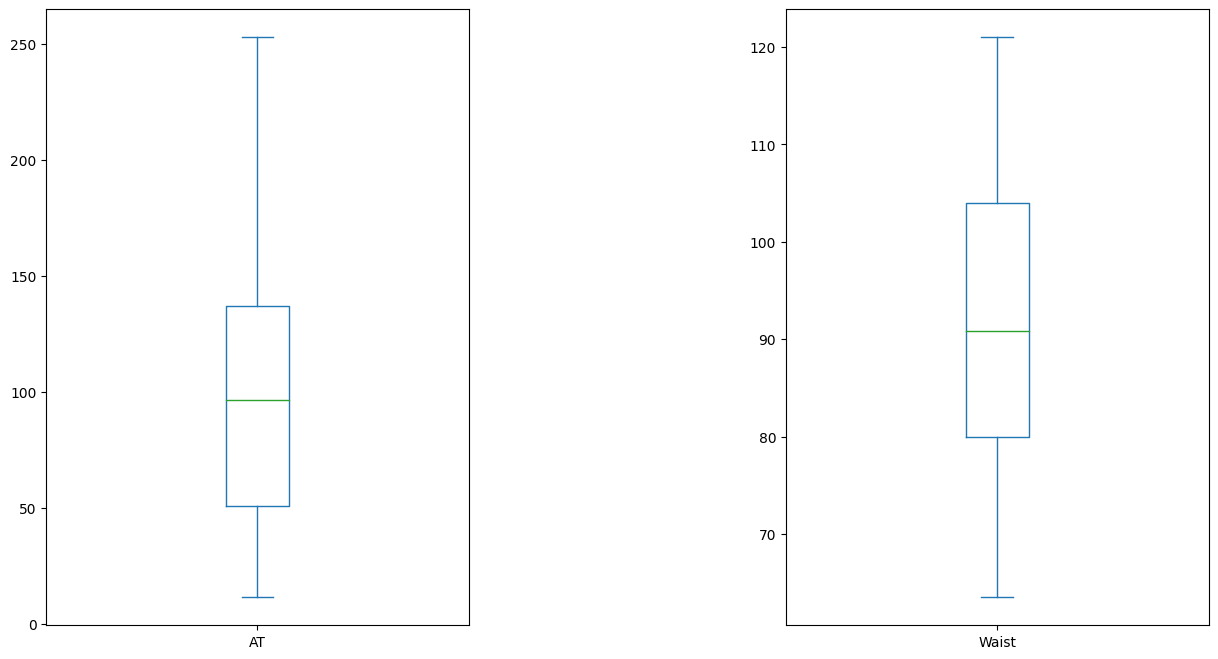

In [17]:
wcat.plot(kind= 'box', subplots = True, sharey = False, figsize =(15,8))
plt.subplots_adjust(wspace = 0.75)

In [18]:
winsor = Winsorizer(capping_method = 'iqr', tail = 'both', fold = 1.5, variables = num_feat)

In [19]:
num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean'))])

In [20]:
outlier_pipeline= Pipeline(steps = [('winsor', winsor)])

In [21]:
preprocessor = ColumnTransformer(transformers = [('num',num_pipeline, num_feat)])
prep_outlier = ColumnTransformer(transformers = [('wins', outlier_pipeline, num_feat)])

In [22]:
impute_data = preprocessor.fit(x)
wcat['Waist'] = pd.DataFrame(impute_data.transform(x))

In [23]:
x2 = pd.DataFrame(wcat['Waist'])
winz_data = prep_outlier.fit(x2)

In [24]:
wcat['Waist'] = pd.DataFrame(winz_data.transform(x))

In [25]:
joblib.dump(impute_data, 'meanimp')
joblib.dump(winz_data,'winz')

['winz']

<BarContainer object of 109 artists>

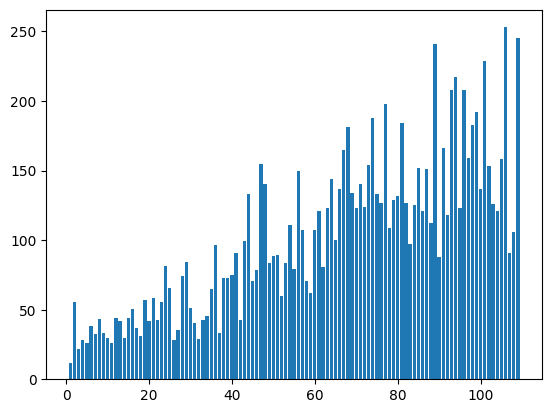

In [26]:
plt.bar(height = wcat.AT, x = np.arange(1,110,1))

(array([14., 18., 16., 13., 17., 14.,  4.,  6.,  3.,  4.]),
 array([ 11.44 ,  35.596,  59.752,  83.908, 108.064, 132.22 , 156.376,
        180.532, 204.688, 228.844, 253.   ]),
 <BarContainer object of 10 artists>)

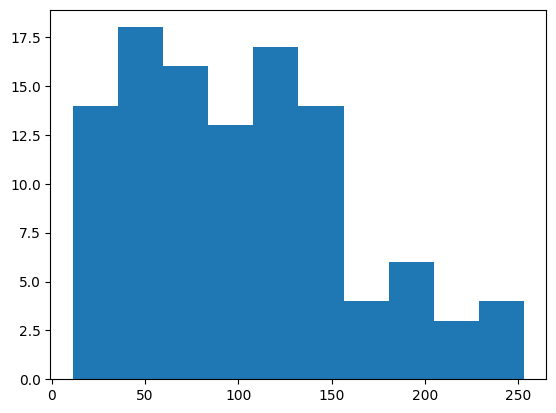

In [27]:
plt.hist(wcat.AT)

(array([ 2.,  9., 19., 17., 11.,  9., 13., 21.,  5.,  3.]),
 array([ 63.5 ,  69.25,  75.  ,  80.75,  86.5 ,  92.25,  98.  , 103.75,
        109.5 , 115.25, 121.  ]),
 <BarContainer object of 10 artists>)

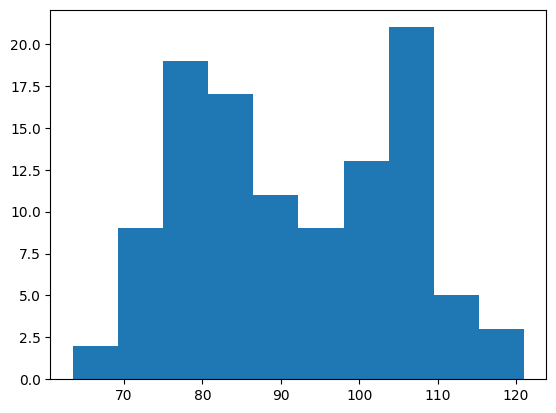

In [28]:
plt.hist(wcat.Waist)

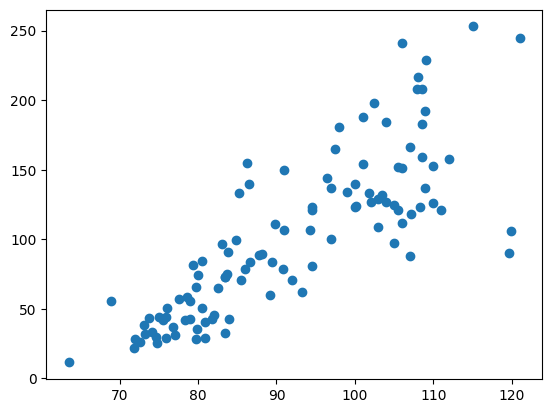

In [29]:
plt.scatter(x= wcat['Waist'], y=wcat['AT'])

In [30]:
np.corrcoef(wcat.Waist, wcat.AT)

array([[1.        , 0.81855781],
       [0.81855781, 1.        ]])

In [31]:
model = smf.ols('AT~Waist', data = wcat).fit()#Y~X

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     AT   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     217.3
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.62e-27
Time:                        07:55:16   Log-Likelihood:                -534.99
No. Observations:                 109   AIC:                             1074.
Df Residuals:                     107   BIC:                             1079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -215.9815     21.796     -9.909      0.000    -259.190    -172.773
Waist          3.4589      0.235     14.740      0.000       2.994       3.924
==============================================================================
Omnibus:                        3.960   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                4.596
Skew:                           0.104   Prob(JB):                        0.100
Kurtosis:                       3.984   Cond. No.                         639.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
pred1 = model.predict(pd.DataFrame(wcat['Waist']))

In [34]:
res1 = wcat.AT - pred1
print(np.mean(res1))

1.1994482878886096e-14


In [51]:
res_sqr = res1*res1
mse1=np.mean(res_sqr)
rmse1 = np.sqrt(mse1)

32.760177495755144

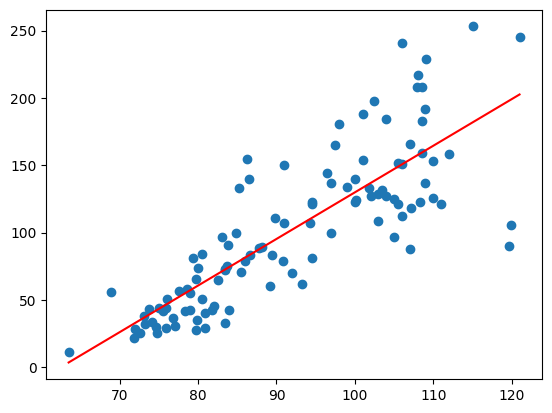

In [36]:
plt.scatter(wcat.Waist, wcat.AT)
plt.plot(wcat.Waist, pred1, "r")# Heteroscedasticity is seen

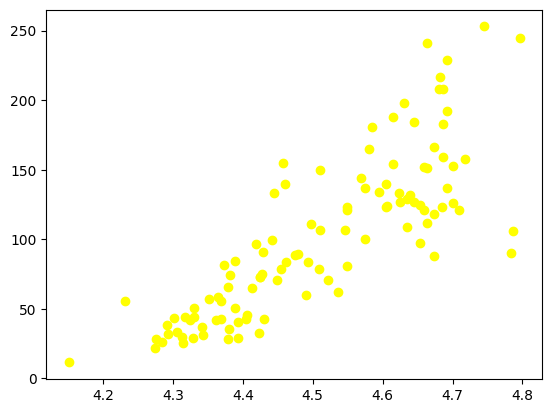

In [37]:
#Transformation
#Log Reg
plt.scatter(x=np.log(wcat['Waist']), y = wcat['AT'], color = 'yellow')

In [38]:
np.corrcoef(np.log(wcat['Waist']), wcat['AT'])

array([[1.        , 0.82177819],
       [0.82177819, 1.        ]])

In [39]:
model2= smf.ols('AT ~ np.log(Waist)', data = wcat ).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     AT   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     222.6
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           6.80e-28
Time:                        07:55:17   Log-Likelihood:                -534.11
No. Observations:                 109   AIC:                             1072.
Df Residuals:                     107   BIC:                             1078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1328.3420     95.923    -13.848      0.000   -1518.498   -1138.186
np.log(Waist)   317.1356     21.258     14.918      0.000     274.994     359.277
==============================================================================
Omnibus:                        3.317   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                2.908
Skew:                           0.235   Prob(JB):                        0.234
Kurtosis:                       3.647   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
pred2 = model2.predict(pd.DataFrame(wcat['Waist']))

In [50]:
res2 = wcat.AT - pred2
res_sqr2 = res2*res2
mse2 = np.mean(res_sqr2)
rmse2 = np.sqrt(mse2)

32.49688490932126

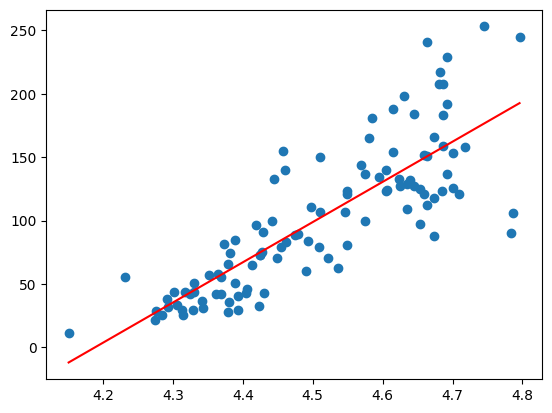

In [42]:
plt.scatter(np.log(wcat['Waist']), wcat['AT'])
plt.plot(np.log(wcat['Waist']), pred2, 'r')

In [43]:
#Quadratic Regression
x = pd.DataFrame(wcat['Waist'])
y = pd.DataFrame(wcat['AT'])

model3 = smf.ols('np.log(AT) ~ Waist + I(Waist*Waist)' , data = wcat).fit() # log(Y) = B0 +B1X +B2X^2
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             np.log(AT)   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     186.8
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.80e-35
Time:                        07:55:17   Log-Likelihood:                -24.779
No. Observations:                 109   AIC:                             55.56
Df Residuals:                     106   BIC:                             63.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.8241      1.473     -5.312      0.000     -10.744      -4.904
Waist                0.2289      0.032      7.107      0.000       0.165       0.293
I(Waist * Waist)    -0.0010      0.000     -5.871      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        0.325   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.271
Skew:                           0.119   Prob(JB):                        0.873
Kurtosis:                       2.949   Cond. No.                     4.49e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
pred3 = model3.predict(pd.DataFrame(wcat))
#Antilog applied
pred3_at = np.exp(pred3)

In [49]:
res3 = wcat.AT - pred3_at
res_sqr3 = res3*res3
mse3 = np.mean(res_sqr3)
rmse3 = np.sqrt(mse3)

32.24444782776205

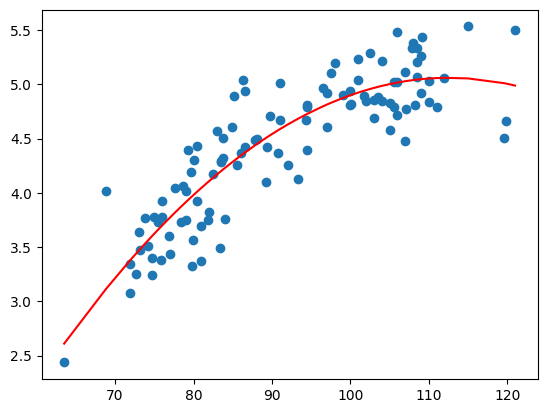

In [46]:
plt.scatter(x['Waist'],np.log(y['AT']))
plt.plot(x['Waist'], pred3, color ='red')

In [47]:
train,test = train_test_split(wcat, test_size = 0.2, random_state = 0)

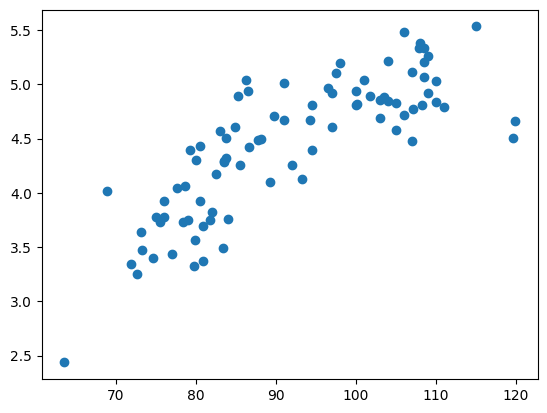

In [48]:
plt.scatter(train.Waist, np.log(train.AT))

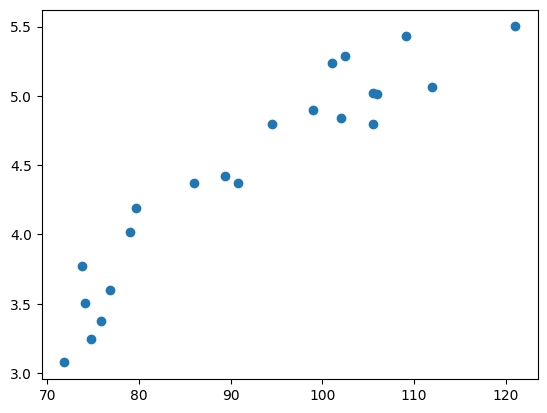

In [52]:
plt.scatter(test.Waist,np.log(test.AT))

In [53]:
final_model = smf.ols('np.log(AT) ~ Waist + I(Waist*Waist)', data = train).fit()

In [55]:
test_pred = final_model.predict(test)
pred_test_at = np.exp(test_pred)

In [56]:
test_res = test.AT - pred_test_at

In [58]:
test_sqr = test_res*test_res
test_mse = np.mean(test_sqr)
test_rmse = np.sqrt(test_mse)

35.96361317390358

In [59]:
train_pred = final_model.predict(pd.DataFrame(train))
pred_train_at = np.exp(train_pred)

In [61]:
train_res = train.AT-pred_train_at
train_sqr = train_res * train_res
train_mse = np.mean(train_sqr)
train_rmse = np.sqrt(train_mse)

32.33045660250123

In [62]:
quad_model = make_pipeline(PolynomialFeatures(degree = 2), LinearRegression())
quad_model.fit(wcat[['Waist']], wcat[['AT']])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [64]:
pickle.dump(quad_model, open('quad_model.pkl','wb'))